# Modulation Mapper

**Goal:** Demonstrate the operation of the modulation mapper and the demodulator

**Steps:**

* We need a simple source and sink for producing a sequence of bits
* How do we describe a constellation?
* How do you implement the modulation mapper?
* What could go wrong? Noise!
* How can we recover the transmitted bits?

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/025_mod_mapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/025_mod_mapper.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [1]:
# import standard libraries",
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

## Sources and Sinks

* Sources produce a sequence of bits
* Over the course of the semester, we will construct a few different sources, including
  + a source for trasmitting a text string
  + a source for transmitting a file, e.g., an image
  + a source that produces randomly generated bits
* The sink is simply an endpoint for a system
  + e.g., we might write received information to a file
  
Today, we implement a string source and sink.

### A simple source - text strings

* For testing, we create a simple source of bits. 
* The source takes a string as an input and generates a vector of 0's and 1's.
* we accomplish this in two steps:
  + converting a string into a sequence of bytes
  + convert each byte into a sequence of 8 bits
* the bit sequence is obtained by concatenating all bits

We begin with converting a byte to 8 bits.

### Converting bytes to bits

* a byte can be viewed as
  + a number between 0 and 255
  + a sequence of 8 bits
  + both perspectives are equivalent
* Our goal is to extract the eight bits that make up the byte. The most-significant bit (MSB) is extracted first.
* We achieve that as follows:
  1. isolate the bit in the first (most significant position)
     - compute the `and` of the byte and the mask `1000 000` (decimal 128)
     - right shift the result by seven bit positions, using `>> 7`
       + this moves the bit we extracted from the MSB position to the LSB position
       + result is either $0$ or $1$; store that
  2. shift all bits by one position towards the MSB
     - computed using the bit-shift operation `<< 1`
     - this drops the bit that we just extracted
  3. repeat eight times until we have all bits
 

In [2]:
def byte_to_bits(b):
    """convert a byte to a sequence of 8 bits (MSB first)"""
    
    # allocate memory for bits
    bits = np.zeros(8, dtype=np.uint8)
    
    # define the mask
    mask = 128
    
    for n in range(8):
        # extract the MSB and store it
        bits[n] = (b & mask) >> 7
        # shift the bits by one position
        b = b << 1
        
    return bits

In [3]:
## Example: 
# 30 decimal is 2^4 + 2^3 + 2^2 + 2^1 => 0001 1110
x = 30
print(f"decimal {x:d} (binary {x:08b}) is converted to: ", byte_to_bits(x))

decimal 30 (binary 00011110) is converted to:  [0 0 0 1 1 1 1 0]


### Converting bits to bytes

* We will also need the reverse operation: given a sequence of (up to eight) bits, compute the corresponding byte
* This can be accomplished as follows:
  + initialize the result `res` to zero
    - data type must be an 8-bit integer `uint8`
  + loop over the bits, assuming that the first bit is the MSB
    - left shift the result by one position, using `<< 1`
      * this is equivalent to multiplying by 2
    - compute the `or` of the current bit and the result

In [4]:
def bits_to_byte(bits):
    """convert a sequence of up to eight bits to a byte"""
    assert len(bits) <= 8, "Can only convert at most 8 bits at a time"
    
    res = np.uint8(0)
    
    for b in bits:
        res = res << 1
        res = res | b
        
    return res

In [5]:
## Check that round-trip conversion works
# check all 256 possible byte values
for n in range(256):
    assert n == bits_to_byte(byte_to_bits(n))

# all good if we get here
print('OK')

OK


### String source: converting a string to bits

* With the `byte_to_bits` function in place, converting a string isn't very hard:

    * loop over the bytes,
    * convert each byte to bits,
    * insert the resulting bits into a vector

* The only complication is that (today) strings may contain *Unicode* characters - not just ASCII.

    * Fortunately, the function `decode()` converts a Unicode string to a sequence of bytes.

In [6]:
def string_source(string):
    """convert a string to a vector of bits"""
    
    # convert a string to a sequence of bytes
    bb = string.encode()
    Nb = len(bb)
    
    # make space
    bits = np.zeros(8 * Nb, dtype=np.uint8)
    
    for n in range(Nb):
        bits[8*n : 8*(n+1)] = byte_to_bits(bb[n])
        
    return bits

In [7]:
## Example:
# convert a short string to bits
string = "Hi"
print(f'The string "{string}" converts to: ', string_source(string) )

The string "Hi" converts to:  [0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1]


### String sink: converting bits to a string

The sink function for strings:
* accepts a sequence of bits
* converts them into the corresponding sequence of bytes
* interprets the sequence of bytes as a Unicode-string (using the `decode()` function)

In [8]:
def string_sink(bits):
    "convert a sequence of bits into a string"
    
    # check that number of bits is a multiple of 8
    if len(bits) % 8 != 0:
        raise ValueError(f'number of bits {len(bits)} is not divisible by 8.')
    
    # allocate storage
    n_bytes = len(bits) // 8
    bytes = np.zeros(n_bytes, dtype=np.uint8)

    for n in range(n_bytes):
        bytes[n] = bits_to_byte(bits[n*8 : (n+1)*8])

    # decode the string (deal with unicode encoding)
    return bytes.tobytes().decode("utf-8", "replace")

In [9]:
## Round-trip test
string = "Hi 😲"
assert string == string_sink( string_source(string) )

print('OK')

OK


## Constellations

Constellations are like look-up tables that maps groups of bits to symbols

* We use a `dict` to store this table:
  + the **keys** hold the group of bits
  + the **values** hold the symbols
* Here is a table for QPSK

In [10]:
QPSK = {
    0b00: 1,
    0b01: 1j,
    0b11: -1,
    0b10: -1j,
}

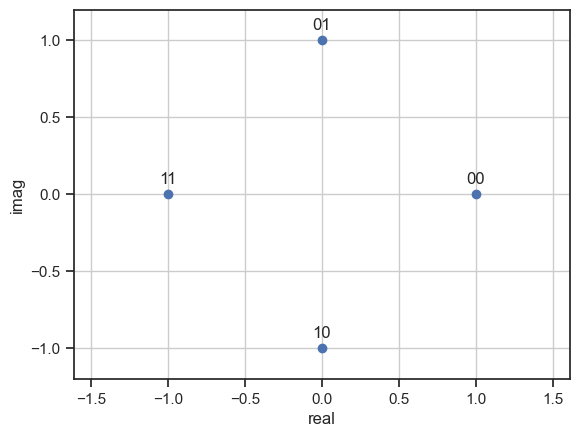

In [11]:
# plot the constellation
for k,v in QPSK.items():
    plt.plot(v.real, v.imag, 'bo', label=f"{k:02b}")
    plt.text(v.real, v.imag+0.05, f"{k:02b}", ha='center', va='bottom')
    
plt.grid()
plt.xlabel('real')
plt.ylabel('imag')
plt.axis('equal')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
#plt.legend()

plt.show()

Note that any two adjacent symbols differ in exactly one bit position. This is called *Gray coding*.

### Helper Functions for Constellations

* Below, we write functions that are useful for characterizing a constellation.

#### Energy per Symbol

* To start, we compute the average symbol energy:
  + that is the average of the squared magnitudes of the symbol values $s[k]$
  $$
  \sigma_A^2 = \frac{1}{K} \sum_{k=0}^{K-1} |s[k]|^2
  $$

In [12]:
def energy_per_symbol(mod_table):
    """compute average energy per symbol"""
    Es = 0
    
    for v in mod_table.values():
        Es += np.abs(v) ** 2

    return Es / len(mod_table)

In [13]:
print(f"The energy per symbol is {energy_per_symbol(QPSK)}")

The energy per symbol is 1.0


#### Energy per Bit and Bits per Symbol

Next up is the energy per bit.

* the energy per bit $E_b$ is the energy per symbol divided by the number of bits per symbol
  + so, we need the number of bits per symbol first

In [14]:
def num_bits_per_symbol(mod_table):
    """Compute number of bits per symbol"""
    return int(np.log2(len(mod_table)))

In [15]:
def energy_per_bit(mod_table):
    """compute average energy per bit"""
    
    return energy_per_symbol(mod_table) / num_bits_per_symbol(mod_table)

In [16]:
print(f"The energy per bit is {energy_per_bit(QPSK)}")

The energy per bit is 0.5


#### Minimum Distance

We are also interested in the square of the minimum distance $d_{min}$ between any pair of points in the constellation.
$$
d_{min} = \min_{n,m, n\neq m} |s[n]-s[m]|^2.
$$

In [17]:
def min_dist_sq(mod_table):
    """compute the square of the minimum distance of the constellation"""
    d_min = np.infty

    for n, s in mod_table.items():
        for m, v in mod_table.items():
            # because of symmetry, we only need to check half of all pairs
            if m <= n:
                continue

            d = np.abs(s - v)**2
            d_min = d if (d < d_min) else d_min

    return d_min

In [18]:
print(f"The square of the minimum distance is: {min_dist_sq(QPSK):4.2f}")

The square of the minimum distance is: 2.00


#### Energy Efficiency

The energy efficiency $\eta$ indicates how much SNR is required to achieve a desired level of performance.
$$
    \eta = \frac{d_{min}^2}{E_b}.
$$


In [19]:
def energy_efficiency(mod_table):
    "Energy efficiency of constellation"

    return min_dist_sq(mod_table) / energy_per_bit(mod_table)

In [20]:
print(f"The energy efficiency is: {energy_efficiency(QPSK):5.3f}")

The energy efficiency is: 4.000


#### Average Number of Nearest Neighbors

Finally, we are interested in the average number $N_{min}$ of neighbors at distance $d_{min}$.

* this is required for the nearest-neighbor approximation to the symbol error rate.

In [21]:
def N_min(mod_table):
    "Compute the average number of nearest neighbors"

    d_min_sq = min_dist_sq(mod_table)

    N_min = 0
    for n, s in mod_table.items():
        for m, v in mod_table.items():
            # because of symmetry, we only need to check half of all pairs
            if m <= n:
                continue

            d_sq = np.abs(s - v)**2
            if np.abs(d_min_sq - d_sq) < 1e-8:
                N_min += 1 
    
    # multiply by 2, since we only visited half of all pairs
    N_min *= 2 / len(mod_table)

    return N_min

In [22]:
print(f"The average number of nearest neighbors is: {N_min(QPSK):4.2f}")

The average number of nearest neighbors is: 2.00


#### Approximate Error Rate

From the above properties we can compute the approximate **symbol error rate** via the nearest neighbor approximation
$$
    \text{Pr}\{\text{symbol error}\} \approx N_{min} \cdot Q(\sqrt{\frac{\eta E_b}{2 N_0}})
$$
in terms of $E_b/N_0$.

In [23]:
from scipy import special

def Q(x):
    """Gaussian error integral"""
    return 0.5 - 0.5*special.erf(x/np.sqrt(2))

In [24]:
def NN_Pr_symbol_error(mod_table, EbN0):
    """compute nearest-neighbor approximation for symbol error rate"""

    NN = N_min(mod_table)
    eta = energy_efficiency(mod_table)

    return Q(np.sqrt(eta/2 * EbN0))

In [25]:
EbN0_dB = 10
EbN0 = 10**(EbN0_dB/10)

print(f"The symbol error rate for Eb/N0 = {EbN0_dB} dB is approximately {NN_Pr_symbol_error(QPSK, EbN0):5.2g}")

The symbol error rate for Eb/N0 = 10 dB is approximately 3.9e-06


## Modulation Mapper:

* A modulation mapper uses a constellation look-up table to map groups of bits to symbols

### Modulation Mapper Function

* a modulation mapper takes $K=\log_2(M)$ bits at a time and maps them to a symbol
  + first the bits are converted to a integer
  + this is very similar to `bits_to_byte`, except the number of bits is often not equal to 8.
* then, the constellation lookup table is used to find the symbol that corresponds to the group of bits.

Below are functions to convert $K$ bits to an integer and back.

In [26]:
def bits_to_int(bits):
    " convert a sequence of bits to an integer"
    res = 0 
    
    for b in bits:
        res = res << 1
        res = res + b
        
    return res

In [27]:
# Example:
bits = np.array([1, 0, 1, 1], dtype=np.uint8)
print( f"The bit sequence {bits} corresponds to decimal {bits_to_int(bits)}" )

The bit sequence [1 0 1 1] corresponds to decimal 11


We will also need the reverse function. This function must specify how many bits to produce.

In [28]:
def int_to_bits(nn, K):
    """Convert an integer to a sequence of K bits (MSB) first"""
    # allocate memory for bits
    bits = np.zeros(K, dtype=np.uint8)
    
    # define the mask
    mask = 1 << (K-1)
    
    for k in range(K):
        # extract the current MSB and store it
        bits[k] = (nn & mask) >> (K-1)
        # shift the bits by one position
        nn = nn << 1
        
    return bits

In [29]:
K = 4
for n in range(2**K):
    assert bits_to_int( int_to_bits(n, K) ) == n
    
print('OK')

OK


Now, we're ready for the modulation mapper itself!

In [30]:
def mod_mapper(bits, mod_table):
    """map a sequence of bits to a sequence of symbols"""
    
    # how many bits per symbol?
    K = int( np.log2(len(mod_table)) )
    
    # how many symbols will we get?
    N = len(bits) // K
    syms = np.zeros(N, dtype=complex)
    
    for n in range(N):
        key = bits_to_int(bits[K*n : K*(n+1)])
        syms[n] = mod_table[key]
        
    return syms

In [31]:
## Example
string = "Hi"
bits = string_source( string )
mod_mapper( bits, QPSK )

array([ 0.+1.j,  1.+0.j, -0.-1.j,  1.+0.j,  0.+1.j, -0.-1.j, -0.-1.j,
        0.+1.j])

### Channel: discrete Gaussian noise channel

* Before implementing the demodulator, we provide a simple, but very relevant channel.
  + The channel simulates the output of the matched filter
  + the noise variance is $\sigma^2 = N_0 \cdot \int |h(t)|^2 \; dt$, where $h(t)$ is the impulse response of the matched filter.
* Each transmitted symbol is corrupted by Gaussian noise
  + the Gaussian noise values are simulated using a random number generator
  + the noise has zero mean and
  + variance `sigma_sq`
* the function `dgnc` below, takes as inputs
  + a sequence of symbols, and
  + a value for `sigma_sq`
* it returns a noisy sequence of symbols

In [32]:
def dgnc(symbols, sigma_sq):
    """discrete Gaussian noise channel"""
    n_syms = len(symbols)
    
    if syms.dtype == complex:
        noise = np.sqrt(sigma_sq/2) * (np.random.randn(n_syms) + 1j * np.random.randn(n_syms))
    else:
        noise = np.sqrt(sigma_sq) * np.random.randn(n_syms)
    
    return symbols + noise

### Received symbols

Let's see the impact that the noisy channel has on the transmitted symbols

* we pass transmitted symbols through the channel, and
* plot the received symbols in the complex plane
  + true symbol locations are shown for reference

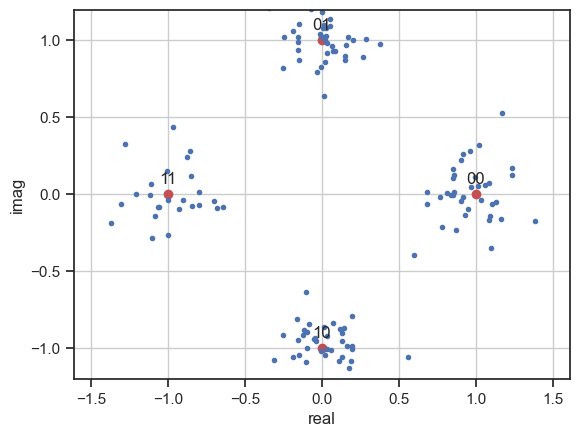

In [33]:
# Transmitter
string = "Now is the time for all good men ..."
bits = string_source( string )
syms = mod_mapper( bits, QPSK )

# Channel
sigma_sq = 0.05
rec_syms = dgnc(syms, sigma_sq)

# plot the constellation
for k,v in QPSK.items():
    plt.plot(v.real, v.imag, 'ro', label=f"{k:02b}")
    plt.text(v.real, v.imag+0.05, f"{k:02b}", ha='center', va='bottom')

# plot the received symbols
plt.plot(rec_syms.real, rec_syms.imag, '.')

plt.grid()
plt.xlabel('real')
plt.ylabel('imag')
plt.axis('equal')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
#plt.legend()

plt.show()

* The noisy symbols are spread out around the transmitted signal locations.

* Our final task is to try and recover the original string from the noisy symbols.

* That is the task of the demodulator.

### Demodulator

* The demodulator finds the most likely transmitted symbol from the received symbols.
* for each received symbol:
  - find the symbol in the constellation that is **closest** to the received symbol
  - the key ('bit pattern') for that symbol is inserted into the received sequence of bits

**Note:** this function is very similar to `MPE_decision_rule`; it returns bits instead of symbols.

In [34]:
def demodulator(syms, mod_table):
    """Recover bit sequence from received symbols"""
    # how many bits per symbol?
    K = int( np.log2(len(mod_table)) )
    
    # how many bits will we get?
    N = len(syms) * K
    bits = np.zeros(N, dtype=np.uint8)

    # put mod_table's symbol values and keys into a Numpy array
    alphabet = np.array(list(mod_table.values()))
    pattern = np.array(list(mod_table.keys()), dtype=int)
    
    # find the constellation point closest to received symbol
    for n in range(len(syms)):
        s = syms[n]
        ind = np.argmin(np.abs(alphabet - s))
        min_k = pattern[ind]
                        
        # the index of the closest symbol is integer `min_k`
        # convert that to a sequence of K bits
        bits[n*K : (n+1)*K] = int_to_bits(min_k, K)
        
    return bits
            

In [35]:
## Let's see if we can get the transmitted string back ...
rec_bits = demodulator(rec_syms, QPSK)
string_sink(rec_bits)

'Now is the time for all good men ...'

## Putting it all together

The code below shows off all the processing steps we have discussed so far.  

We will build on this example as the semester progressess.

In [36]:
## Define another constellation: BPSK
BPSK = {0b0: 1,
        0b1: -1}

In [37]:
## Transmitter:
# Source
string = "ECE 632 is my favorite class"
bits = string_source(string)
# Modulation mapper
syms = mod_mapper(bits, BPSK)

## Channel
sigma_sq = 0.1
rec_syms = dgnc(syms, sigma_sq)

## Receiver
# Demodulator
rec_bits = demodulator(rec_syms, BPSK)
# Sink
string_sink(rec_bits)

'ECE 632 is my favorite class'